Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.interpolate import interp1d
import tensorflow as tf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
features_df = pd.read_excel('terra.xlsx', sheet_name='g4.areaAvgTimeSeries.MOD08_D3_6', skiprows=8)

In [ ]:
features_df.columns = ['Date', 'AOD']

In [ ]:
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [ ]:
features_df.set_index('Date', inplace=True)

Missing Value Imputation

In [ ]:
features_df.isnull().sum()

,0
AOD,2365


In [ ]:
missing_percent = features_df['AOD'].isnull().mean() * 100

In [ ]:
print(f"Percentage of missing values: {missing_percent:.2f}%")

Percentage of missing values: 31.82%


In [ ]:
features_df['AOD'] = features_df['AOD'].interpolate(method='spline', order=3).fillna(method='bfill')

/tmp/ipython-input-108-1765457206.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['AOD'] = features_df['AOD'].interpolate(method='spline', order=3).fillna(method='bfill')


In [ ]:
features_df.shape

(7433, 1)

In [ ]:
features_df.isnull().sum()

,0
AOD,0


In [ ]:
features_df.head()

,AOD
Date,
2005-01-01,1.405000
2005-01-02,1.405000
2005-01-03,0.610307
2005-01-04,0.390000
2005-01-05,0.405000


In [ ]:
features_df.tail()

,AOD
Date,
2025-05-27,1.329
2025-05-28,1.201
2025-05-29,0.762
2025-05-30,1.671
2025-05-31,0.778


In [ ]:
features_df['AOD'].dtype

dtype('float64')

In [ ]:
aod_series = features_df['AOD'].copy()

In [ ]:
aod_series

,AOD
Date,
2005-01-01,1.405000
2005-01-02,1.405000
2005-01-03,0.610307
2005-01-04,0.390000
2005-01-05,0.405000
...,...
2025-05-27,1.329000
2025-05-28,1.201000
2025-05-29,0.762000


Feature Engineering

In [ ]:
features_df['year'] = features_df.index.year
features_df['month'] = features_df.index.month
features_df['day'] = features_df.index.day
features_df['day_of_year'] = features_df.index.dayofyear
features_df['week_of_year'] = features_df.index.isocalendar().week
features_df['AOD_lag1'] = features_df['AOD'].shift(1)
features_df['AOD_lag3'] = features_df['AOD'].shift(3)
features_df['AOD_lag7'] = features_df['AOD'].shift(7)
features_df['rolling_mean_7'] = features_df['AOD'].rolling(window=7).mean()
features_df['rolling_std_7'] = features_df['AOD'].rolling(window=7).std()
features_df['rolling_mean_30'] = features_df['AOD'].rolling(window=30).mean()
features_df.dropna(inplace=True)

In [ ]:
target_df = pd.read_excel('Aeronet_Ground.xlsx',skiprows=1)
target_df['Date'] = pd.to_datetime(target_df['Date'])
target_df.set_index('Date', inplace=True)

In [ ]:
print(target_df.columns)

Index(['AOD_550 nm'], dtype='object')


In [ ]:
df = features_df.merge(target_df[['AOD_550 nm']], left_index=True, right_index=True)

In [ ]:
df.dropna(subset=['AOD_550 nm'], inplace=True)  # critical step!

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,1.643000,2010,1,8,8,1,1.094000,0.732223,1.253000,1.286069,0.846172,0.921872,1.328404
2010-01-12,0.732481,2010,1,12,12,2,0.732444,0.732370,0.732223,1.246243,0.867513,0.907154,1.023497
2010-01-13,0.732518,2010,1,13,13,2,0.732481,0.732407,3.057000,0.914174,0.348486,0.907191,1.545134
2010-01-14,1.305000,2010,1,14,14,2,0.732518,0.732444,1.094000,0.944317,0.374767,0.910025,0.804563
2010-01-15,0.732591,2010,1,15,15,2,1.305000,0.732481,1.643000,0.814259,0.216397,0.899678,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.766831,2019,9,24,267,39,0.766828,0.766823,0.766813,0.766823,0.000005,0.755503,0.351707
2019-09-25,0.766833,2019,9,25,268,39,0.766831,0.766826,0.766815,0.766826,0.000005,0.755505,0.299810
2019-09-30,0.766846,2019,9,30,273,40,0.766843,0.766838,0.766828,0.766838,0.000006,0.766809,0.172924
2019-10-01,0.766849,2019,10,1,274,40,0.766846,0.766841,0.766831,0.766841,0.000006,0.766812,0.768491
2019-10-04,0.476000,2019,10,4,277,40,0.766854,0.766849,0.766838,0.725298,0.109930,0.757124,0.358606


In [ ]:
df.shape

(2412, 13)

Exploratory Data Visulations

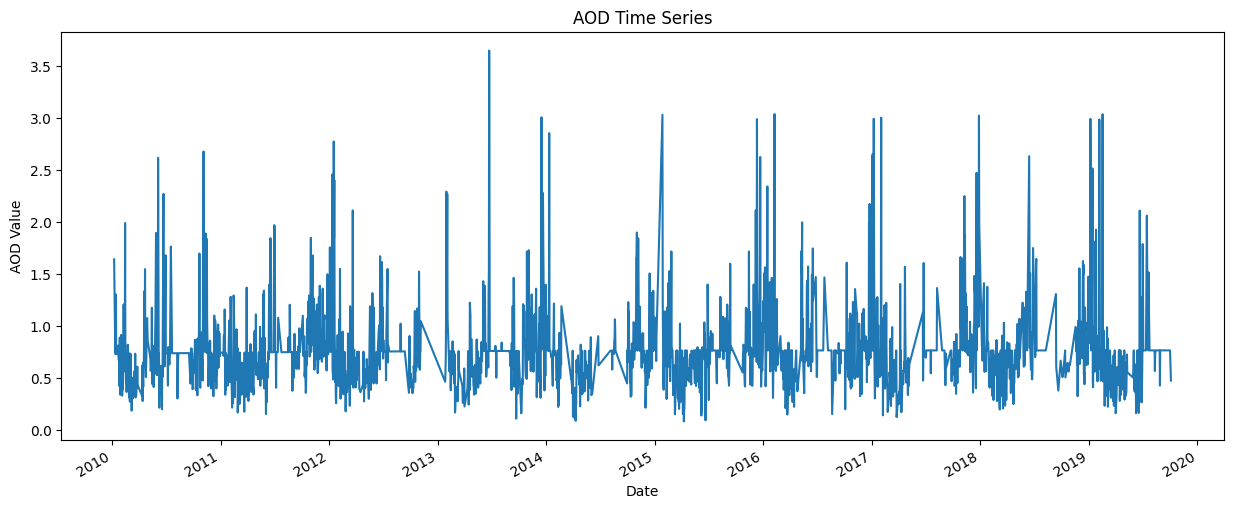

In [ ]:
plt.figure(figsize=(15, 6))
df['AOD'].plot(title='AOD Time Series')
plt.ylabel('AOD Value')
plt.show()

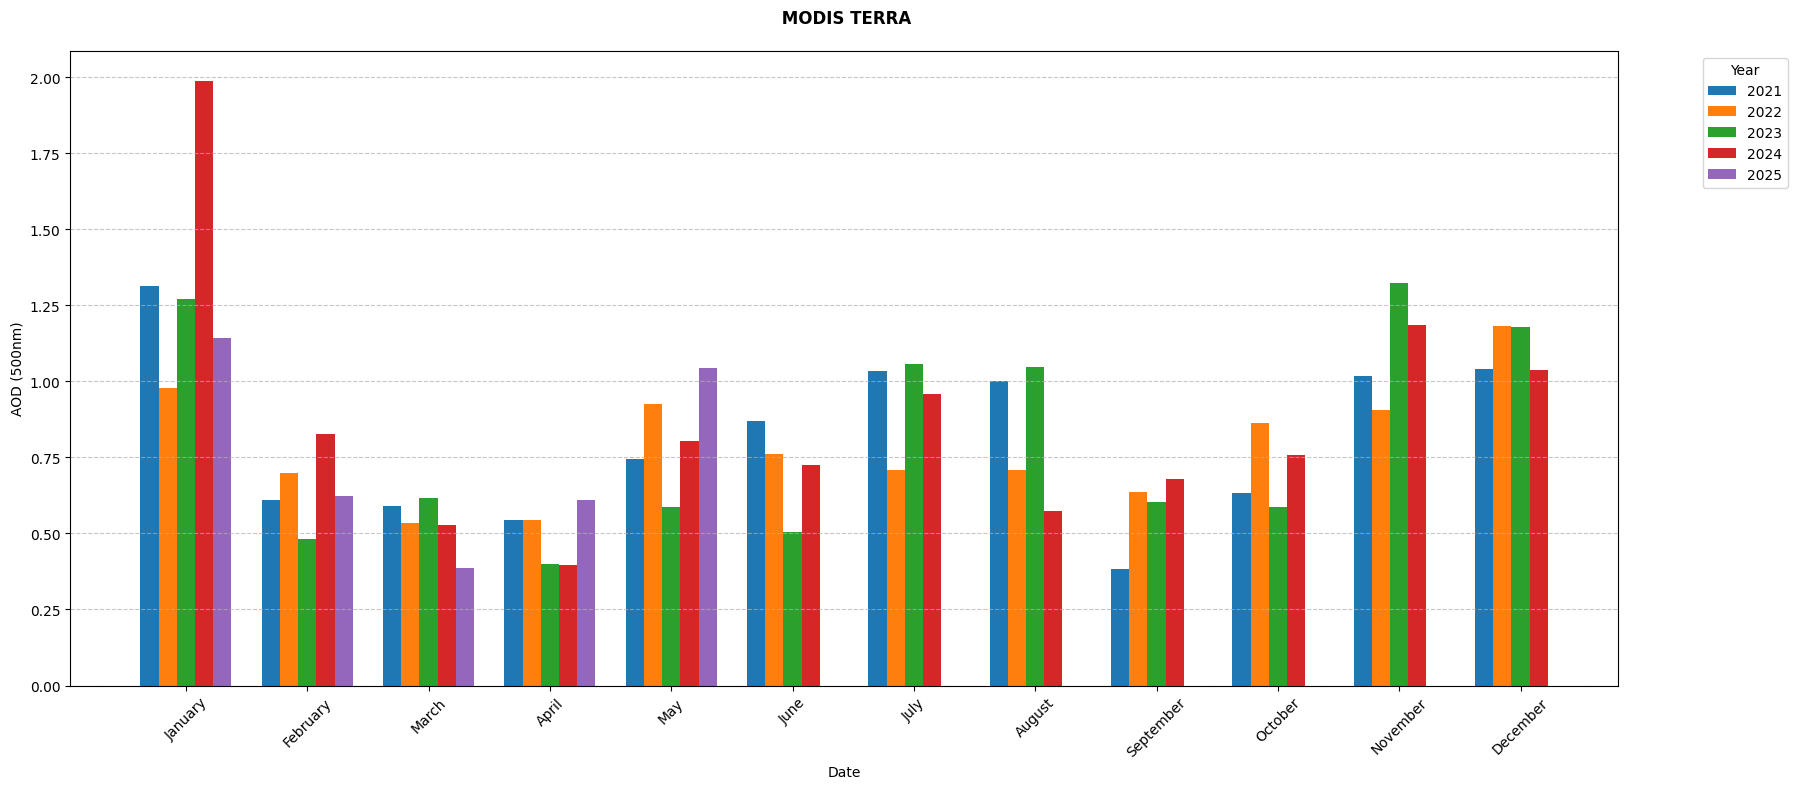

In [ ]:
sd_df = pd.read_excel('terra(monthly-kanpur).xlsx', sheet_name='g4.areaAvgTimeSeries.MOD08_M3_6',skiprows=8)
sd_df['Date'] = pd.to_datetime(sd_df['time'])
sd_df = sd_df[(sd_df['Date'].dt.year >= 2021) & (sd_df['Date'].dt.year <= 2025)]

# Extract month and year
sd_df['Month'] = sd_df['Date'].dt.month_name()
sd_df['Year'] = sd_df['Date'].dt.year

# Pivot table for grouped bars
pivot_df = sd_df.pivot_table(index='Month', columns='Year', values='AOD_550nm', aggfunc='mean')

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_df = pivot_df.reindex(month_order)

# Plot
plt.figure(figsize=(18, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct colors for each year
width = 0.15  # Width of each bar

for i, year in enumerate(pivot_df.columns):
    positions = np.arange(len(pivot_df)) + i * width
    plt.bar(positions, pivot_df[year], width=width, label=year, color=colors[i])

plt.title(' MODIS TERRA', fontweight='bold', pad=20)
plt.xlabel('Date')
plt.ylabel('AOD (500nm)')
plt.xticks(np.arange(len(pivot_df)) + width * 2, pivot_df.index, rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Outlier Detection and Removal

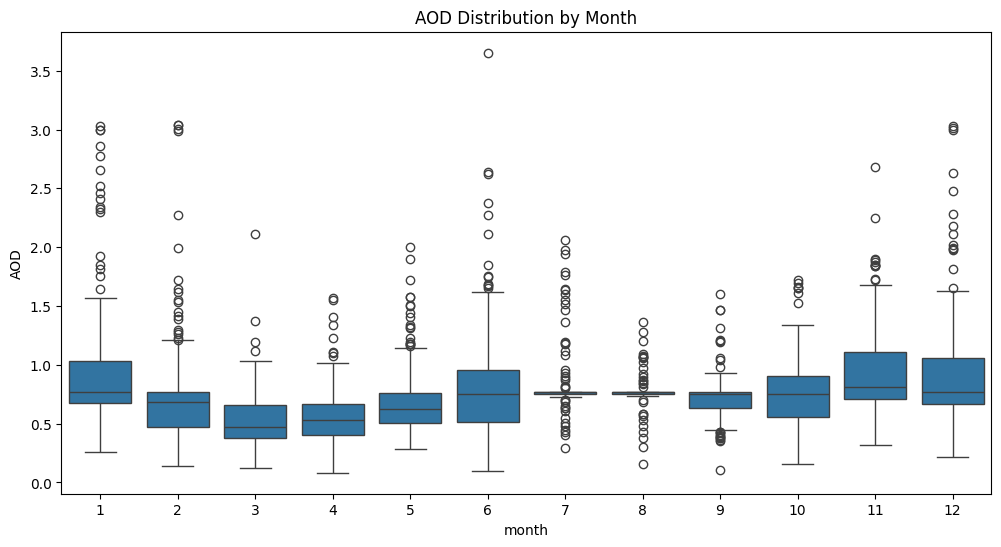

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AOD', data=df)
plt.title('AOD Distribution by Month')
plt.show()

In [ ]:
z_scores = stats.zscore(df['AOD'])
abs_z_scores = np.abs(z_scores)
outliers = abs_z_scores > 3

In [ ]:
print(f"Number of outliers detected: {outliers.sum()}")

Number of outliers detected: 44


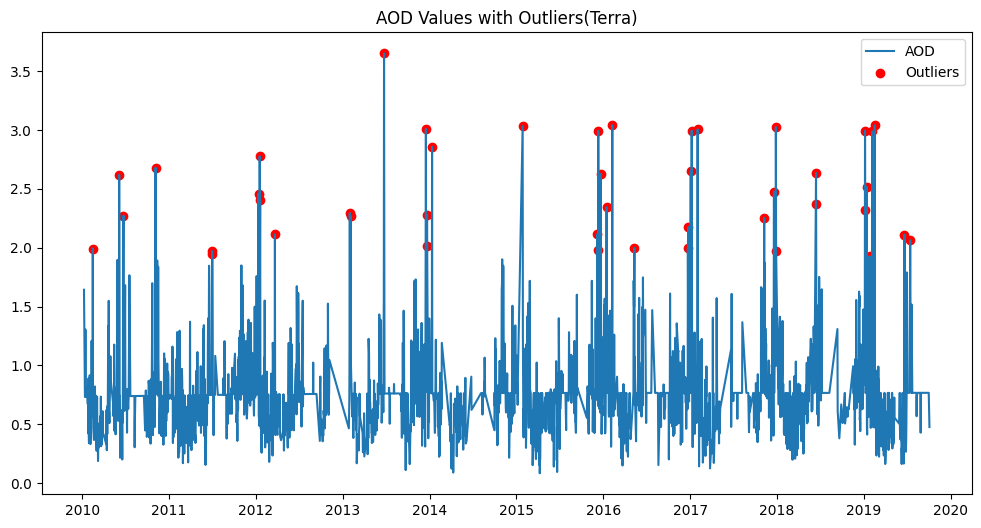

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AOD'], label='AOD')
plt.scatter(df.index[outliers], df['AOD'][outliers], color='red', label='Outliers')
plt.title('AOD Values with Outliers(Terra)')
plt.legend()
plt.show()

In [ ]:
mean_aod = df['AOD'].mean()
std_aod = df['AOD'].std()

In [ ]:
upper_bound = mean_aod + 3 * std_aod
lower_bound = mean_aod - 3 * std_aod

In [ ]:
df['AOD'] = df['AOD'].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,1.643000,2010,1,8,8,1,1.094000,0.732223,1.253000,1.286069,0.846172,0.921872,1.328404
2010-01-12,0.732481,2010,1,12,12,2,0.732444,0.732370,0.732223,1.246243,0.867513,0.907154,1.023497
2010-01-13,0.732518,2010,1,13,13,2,0.732481,0.732407,3.057000,0.914174,0.348486,0.907191,1.545134
2010-01-14,1.305000,2010,1,14,14,2,0.732518,0.732444,1.094000,0.944317,0.374767,0.910025,0.804563
2010-01-15,0.732591,2010,1,15,15,2,1.305000,0.732481,1.643000,0.814259,0.216397,0.899678,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.766831,2019,9,24,267,39,0.766828,0.766823,0.766813,0.766823,0.000005,0.755503,0.351707
2019-09-25,0.766833,2019,9,25,268,39,0.766831,0.766826,0.766815,0.766826,0.000005,0.755505,0.299810
2019-09-30,0.766846,2019,9,30,273,40,0.766843,0.766838,0.766828,0.766838,0.000006,0.766809,0.172924
2019-10-01,0.766849,2019,10,1,274,40,0.766846,0.766841,0.766831,0.766841,0.000006,0.766812,0.768491
2019-10-04,0.476000,2019,10,4,277,40,0.766854,0.766849,0.766838,0.725298,0.109930,0.757124,0.358606


Feature Selection

In [ ]:
df.reset_index(inplace=True)

In [ ]:
X = df.drop(columns=[ 'AOD_550 nm','Date'])
y = df['AOD_550 nm']

In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
X

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30
0,1.643000,2010,1,8,8,1,1.094000,0.732223,1.253000,1.286069,0.846172,0.921872
1,0.732481,2010,1,12,12,2,0.732444,0.732370,0.732223,1.246243,0.867513,0.907154
2,0.732518,2010,1,13,13,2,0.732481,0.732407,3.057000,0.914174,0.348486,0.907191
3,1.305000,2010,1,14,14,2,0.732518,0.732444,1.094000,0.944317,0.374767,0.910025
4,0.732591,2010,1,15,15,2,1.305000,0.732481,1.643000,0.814259,0.216397,0.899678
...,...,...,...,...,...,...,...,...,...,...,...,...
2407,0.766831,2019,9,24,267,39,0.766828,0.766823,0.766813,0.766823,0.000005,0.755503
2408,0.766833,2019,9,25,268,39,0.766831,0.766826,0.766815,0.766826,0.000005,0.755505
2409,0.766846,2019,9,30,273,40,0.766843,0.766838,0.766828,0.766838,0.000006,0.766809
2410,0.766849,2019,10,1,274,40,0.766846,0.766841,0.766831,0.766841,0.000006,0.766812


In [ ]:
y

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
2407,0.351707
2408,0.299810
2409,0.172924
2410,0.768491


Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
X_train.shape

(1929, 12)

In [ ]:
X_test.shape

(483, 12)

In [ ]:
y_train.shape

(1929,)

In [ ]:
y_test.shape

(483,)

Feature Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[ 2.73194616, -1.44266476, -1.50237354, ...,  2.46706598,
         3.34400471,  1.1110963 ],
       [-0.02578861, -1.44266476, -1.50237354, ...,  2.28519658,
         3.46261844,  1.01771589],
       [-0.02567713, -1.44266476, -1.50237354, ...,  0.76875849,
         0.57777703,  1.01795186],
       ...,
       [ 1.70519974,  1.59212295,  1.03460798, ...,  0.97867973,
         0.80835347, -0.08612939],
       [ 0.16053701,  1.59212295,  1.03460798, ...,  1.03608888,
         0.76262863, -0.03685363],
       [ 2.76223366,  1.59212295,  1.03460798, ...,  1.71717019,
         0.96505716,  0.0733295 ]])

In [ ]:
X_test_scaled

array([[ 0.47552706,  1.59212295,  1.03460798, ...,  1.85482169,
         0.79806123,  0.10118672],
       [ 1.55981972,  1.59212295,  1.31649482, ...,  2.16926727,
         0.59089554,  0.25345516],
       [ 0.07655461,  1.59212295,  1.31649482, ...,  1.58295777,
         0.44553518,  0.29242565],
       ...,
       [ 0.07829445,  2.45920515,  0.75272115, ...,  0.09592797,
        -1.35913565,  0.12729616],
       [ 0.07830232,  2.45920515,  1.03460798, ...,  0.09593974,
        -1.35913557,  0.12731199],
       [-0.80260564,  2.45920515,  1.03460798, ..., -0.09377276,
        -0.74815673,  0.06584826]])

In [ ]:
y_train

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
1924,1.377375
1925,1.091791
1926,0.993482
1927,0.815775


Model Training

Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor( n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42)

In [ ]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [ ]:
rf_pred = rf_model.predict(X_test_scaled)

In [ ]:
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = root_mean_squared_error(y_test, rf_pred)
rf_rmse=r2_score(y_test,rf_pred)

In [ ]:
print("\nRandom Forest Performance:")
print(f"MSE: {rf_mse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"RMSE: {rf_r2:.4f}")
print(f"R2:{rf_rmse:.4f}")


Random Forest Performance:
MSE: 0.0536
MAE: 0.1677
RMSE: 0.2315
R2:0.5010


Multi Layer Perceptron

In [ ]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate_init=0.005,
    alpha=0.0001,
    batch_size=32,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

In [ ]:
mlp_model.fit(X_train_scaled, y_train)

MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(100, 50),
             learning_rate_init=0.005, max_iter=5000, n_iter_no_change=20,
             random_state=42)

In [ ]:
mlp_pred = mlp_model.predict(X_test_scaled)

In [ ]:
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = root_mean_squared_error(y_test, mlp_pred)
mlp_rmse=r2_score(y_test,mlp_pred)

In [ ]:
print("\nMLP Performance:")
print(f"MSE: {mlp_mse:.4f}")
print(f"MAE: {mlp_mae:.4f}")
print(f"RMSE: {mlp_r2:.4f}")
print(f"R2:{mlp_rmse:.4f}")


MLP Performance:
MSE: 0.0652
MAE: 0.1914
RMSE: 0.2554
R2:0.3927


Long Short Term Memory(LSTM)

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

In [ ]:
n_steps = 30
X_lstm, y_lstm = create_sequences(df['AOD_550 nm'].values, n_steps)

In [ ]:
split_idx = int(0.8 * len(X_lstm))
split_idx

1905

In [ ]:
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [ ]:
X_train_lstm.shape

(1905, 30)

In [ ]:
X_test_lstm.shape

(477, 30)

In [ ]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [ ]:
X_train_lstm.shape

(1905, 30, 1)

In [ ]:
X_test_lstm.shape

(477, 30, 1)

In [ ]:
lstm_model = Sequential([
    Input(shape=(n_steps, 1)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.1503 - val_loss: 0.1062
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0886 - val_loss: 0.0870
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0868 - val_loss: 0.0880
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0824 - val_loss: 0.0836
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0845 - val_loss: 0.0860
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0803 - val_loss: 0.0808
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0798 - val_loss: 0.0835
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0791 - val_loss: 0.0754
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0672 - val_loss: 0.0766
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0715 - val_loss: 0.0785
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0791 - val_loss: 0.0797
Epoch 12/100
120/120 ━━━━━━━━━

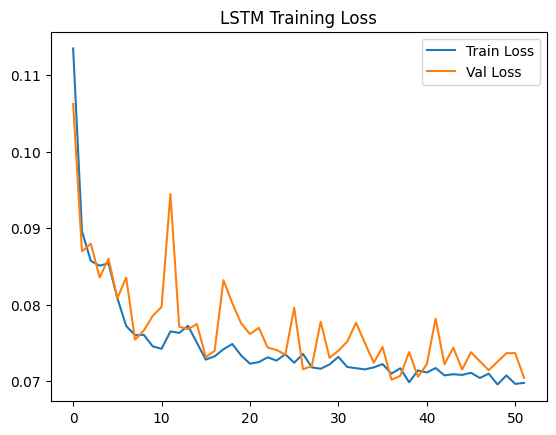

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [ ]:
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
lstm_r2 = root_mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_rmse=r2_score(y_test_lstm,y_pred_lstm)

In [ ]:
print("\nSimplified LSTM Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"Rmse: {lstm_r2:.4f}")
print(f"R2:{lstm_rmse:.4f}")


Simplified LSTM Performance:
MSE: 0.0702
MAE: 0.1885
Rmse: 0.2649
R2:0.3342


In [ ]:
plt.figure(figsize=(18, 10))

# Define common axis limits
all_actual = np.concatenate([y_test, y_test_lstm])
all_predicted = np.concatenate([rf_pred, mlp_pred, y_pred_lstm])
ax_min = min(all_actual.min(), all_predicted.min()) * 0.9
ax_max = max(all_actual.max(), all_predicted.max()) * 1.1

<Figure size 1800x1000 with 0 Axes>

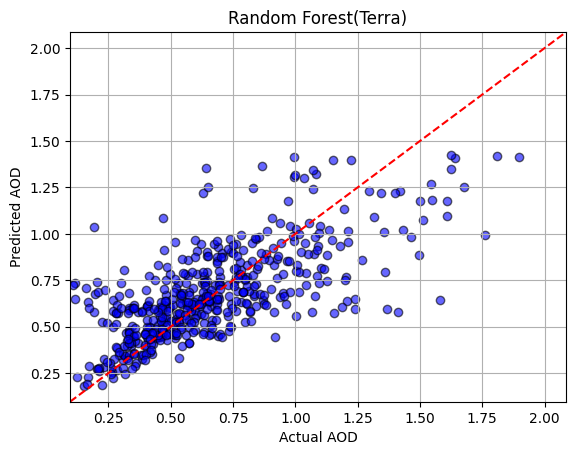

In [ ]:

plt.scatter(y_test, rf_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'Random Forest(Terra)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

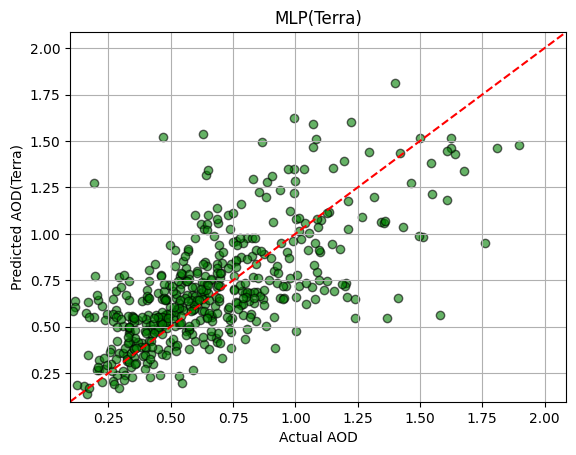

In [ ]:
plt.scatter(y_test, mlp_pred, alpha=0.6, color='green', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD(Terra)')
plt.title(f'MLP(Terra)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

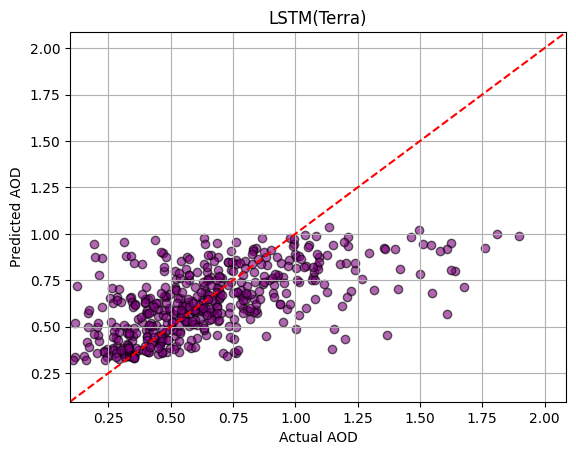

In [ ]:
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color='purple', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'LSTM(Terra)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

In [ ]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'MLP', 'LSTM'],
    'MSE': [rf_mse, mlp_mse, lstm_mse],
    'MAE': [rf_mae, mlp_mae, lstm_mae],
    'R²': [rf_r2, mlp_r2, lstm_r2]
})

In [ ]:
print("\nModel Comparison:")
print(model_comparison)
best_model_idx = np.argmin(model_comparison['MSE'])
best_model_name = model_comparison.loc[best_model_idx, 'Model']


Model Comparison:
           Model       MSE       MAE        R²
0  Random Forest  0.053585  0.167689  0.231484
1            MLP  0.065218  0.191416  0.255377
2           LSTM  0.070187  0.188540  0.264928


In [ ]:
aod_series.shape

(7433,)

In [ ]:
aod_series.index = pd.to_datetime(aod_series.index)

In [ ]:
aod_series = aod_series.asfreq('D').interpolate(method='time')

In [ ]:
n_days = 30
train = aod_series[:-n_days]
test = aod_series[-n_days:]

In [ ]:
model = ARIMA(aod_series, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
print("\n📋 Forecast Table (Last 30 Days):")
print(forecast_df)


📋 Forecast Table (Last 30 Days):
            Actual_AOD  Forecasted_AOD
Date                                  
2025-05-02    2.729000        0.980083
2025-05-03    0.685000        1.032711
2025-05-04    0.904000        1.046417
2025-05-05    0.800999        1.049987
2025-05-06    0.627000        1.050917
2025-05-07    0.801074        1.051159
2025-05-08    0.772000        1.051222
2025-05-09    1.026000        1.051238
2025-05-10    0.584000        1.051242
2025-05-11    1.425000        1.051244
2025-05-12    0.801262        1.051244
2025-05-13    0.615000        1.051244
2025-05-14    0.396000        1.051244
2025-05-15    0.471000        1.051244
2025-05-16    0.617000        1.051244
2025-05-17    0.801451        1.051244
2025-05-18    0.659000        1.051244
2025-05-19    0.696000        1.051244
2025-05-20    0.853000        1.051244
2025-05-21    1.083000        1.051244
2025-05-22    0.544000        1.051244
2025-05-23    1.282000        1.051244
2025-05-24    1.705000        

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 30),
                enforce_stationarity=False,
                enforce_invertibility=False)

In [ ]:
model_fit = model.fit(disp=False)

In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

print("\n SARIMA Forecast Table:")
print(forecast_df.head(10))


 SARIMA Forecast Table:
            Actual_AOD  Forecasted_AOD
Date                                  
2025-05-02    2.729000        0.866815
2025-05-03    0.685000        0.776362
2025-05-04    0.904000        0.752243
2025-05-05    0.800999        0.749976
2025-05-06    0.627000        0.752226
2025-05-07    0.801074        0.724957
2025-05-08    0.772000        0.743332
2025-05-09    1.026000        0.746981
2025-05-10    0.584000        0.771028
2025-05-11    1.425000        0.782668
